In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import shannon

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

# Information analysis  
  
  Still some aspects of this analysis are counter-intuitive. For instance, the horizontal weight should presumably be much lower for such a high SNR. And why don't we see diverse horizontal weights? Let's move to an analysis where we specifically compute the mutual information.

In [4]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [5]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [6]:
blah = generate_spatial_signals(10000)

In [7]:
blah.shape

(10000, 398)

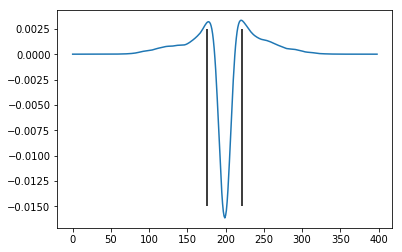

In [21]:
plt.plot(rf_model(0.5, 0.5))
plt.vlines(176, -0.015, 0.0025)
plt.vlines(222, -0.015, 0.0025)

In [34]:
t = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5))
t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_model(0.5, 0.5)[::-1])
t2 = t_rev[::-1, ::-1]

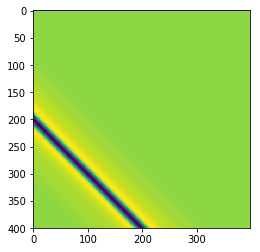

In [35]:
plt.imshow(t2)

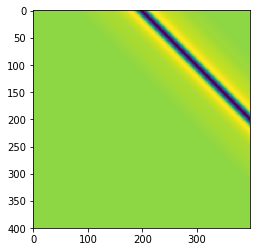

In [23]:
plt.imshow(t)

In [40]:
filters = np.vstack([t2, t])[200:-200]

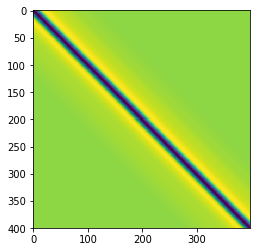

In [41]:
plt.imshow(filters)

In [53]:
filters_sparse = filters[25:-25:50]

In [54]:
filters_sparse.shape

(7, 399)

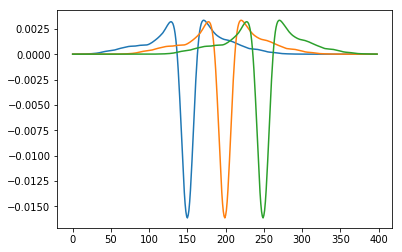

In [55]:
plt.plot(filters[150])
plt.plot(filters[200])
plt.plot(filters[250])

In [56]:
sigma_f = np.cov(filters_sparse)

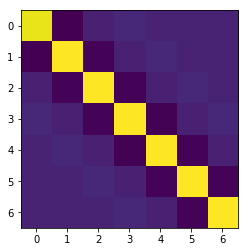

In [57]:
plt.imshow(sigma_f)

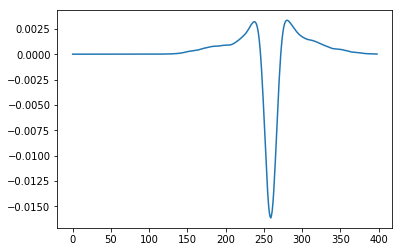

In [31]:
plt.plot(t[60])

In [78]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [79]:
f = filter_bank([0.2, 0.5], [0.6, 0.5])

In [80]:
f.shape

(14, 399)

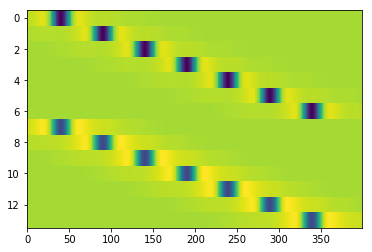

In [81]:
plt.imshow(f, aspect='auto')

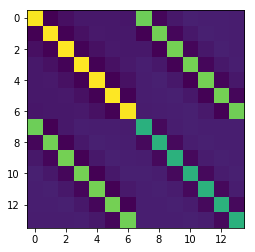

In [83]:
plt.imshow(np.cov(f))

In [90]:
f.shape

(14, 399)

In [91]:
spatial_signals = generate_spatial_signals(1000)
spatial_signals.shape

(1000, 398)

In [95]:
np.cov(np.dot(f[:, :-1], spatial_signals.T)).shape

(14, 14)

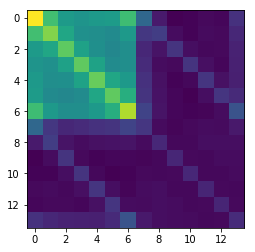

In [96]:
plt.imshow(np.cov(np.dot(f[:, :-1], spatial_signals.T)))

In [108]:
sigma_s = np.cov(np.dot(f[:, :-1], spatial_signals.T))
sigma_n = np.cov(f)

In [109]:
sigma_t = sigma_s + sigma_n

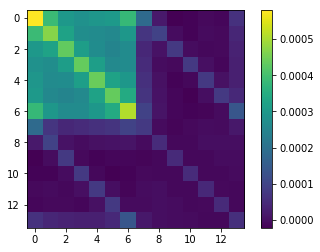

In [110]:
plt.imshow(sigma_t)
plt.colorbar()

In [111]:
chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_t))))
chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(sigma_n))))

In [112]:
chol_t

-77.127643867654484

In [113]:
chol_n

-96.296504612616431

In [114]:
chol_t - chol_n

19.168860744961947

In [115]:
? scipy.optimize.minimize

In [120]:
def mutual_information(hws, cws, samples=1000, target_snr=7.5, input_noise=0.1, output_noise=0.3):
    '''Mutual information between a spatial signal and the output of a bank of filters.
    
    Args:
        hws: horizontal weightings for the filter bank.
        cws: center weightings for the filter bank.
        samples: number of observations to generate.
        target_snr: signal-to-noise ratio to constrain the filter banks.
    Returns:
        info: Mutual information between x and y in nats.
    '''
    spatial_signals = generate_spatial_signals(samples)
    filters = filter_bank(hws, cws)
    sigma_f = np.cov(filters)
    sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
    
    def sigmas(filter_constants, return_snr=False):
        ff_const = np.outer(filter_constants, filter_constants)
        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n
        
        signal_var = np.diag(sigma_signal)
        noise_var = np.diag(sigma_n)
        snr = signal_var/noise_var
        if return_snr:
            return snr
        else:
            return sigma_t, sigma_n
        
    def mse(filter_constants):
        snr = sigmas(filter_constants, return_snr=True)
        return np.mean((snr - target_snr)**2)
    
    res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
    opt_filter_const = res.x
    
    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    return 0.5 * (chol_t - chol_n)

In [133]:
mi = mutual_information([0.5], [1.0])

In [134]:
mi

11.371541023160821

In [148]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        samples = 1000
        target_snr = 10.5
        input_noise = 0.1
        output_noise = 0.35
        spatial_signals = generate_spatial_signals(samples)
        filters = filter_bank(hws, cws)
        sigma_f = np.cov(filters)
        sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))

        def sigmas(filter_constants, return_snr=False):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_snr:
                return snr
            else:
                return sigma_t, sigma_n

        def mse(filter_constants):
            snr = sigmas(filter_constants, return_snr=True)
            return np.mean((snr - target_snr)**2)

        res = scipy.optimize.minimize(mse, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = res.x

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi


0it [00:00, ?it/s]
1it [00:04,  4.73s/it]
20it [01:31,  4.50s/it]


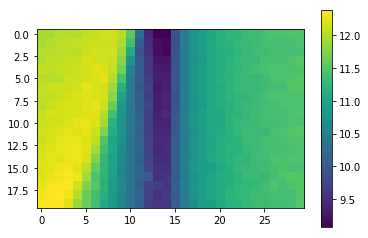

In [151]:
plt.imshow(info_map[:20, :30])
plt.colorbar()

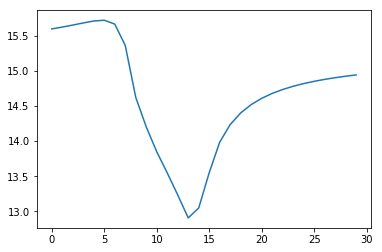

In [215]:
plt.plot(info_map[:20, :30][10])

In [221]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
# target_power = 48.053365503112332 #54.131410989171826
target_power = 100.
target_snr = 0.5

In [195]:
old_info_map = info_map

In [222]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [229]:
opt_filter_const.shape

(7,)

In [228]:
filters.shape

(7, 399)

In [233]:
(filters.T * opt_filter_const).T

(7, 399)

In [238]:
(np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

array([[  2.48243046e-004,   7.26720132e-009,   1.90912053e-022,
          4.24544234e-045,   4.23904261e-076,   1.08270742e-116,
          2.32805720e-166],
       [  7.26720132e-009,   2.45295605e-004,   7.42999287e-009,
          1.90506795e-022,   1.44494439e-044,   4.25526821e-076,
          1.05497446e-116],
       [  1.90912053e-022,   7.42999287e-009,   2.59489329e-004,
          7.67138982e-009,   4.41988060e-022,   1.50078617e-044,
          4.29008898e-076],
       [  4.24544234e-045,   1.90506795e-022,   7.67138982e-009,
          2.61493607e-004,   1.14444094e-008,   4.48057903e-022,
          1.47677420e-044],
       [  4.23904261e-076,   1.44494439e-044,   4.41988060e-022,
          1.14444094e-008,   2.52760732e-004,   7.51702832e-009,
          1.88201018e-022],
       [  1.08270742e-116,   4.25526821e-076,   1.50078617e-044,
          4.48057903e-022,   7.51702832e-009,   2.57759833e-004,
          7.44086624e-009],
       [  2.32805720e-166,   1.05497446e-116,   4.29

In [240]:
residual = (np.outer(opt_filter_const, opt_filter_const) * np.dot(filters, filters.T)) - (
    np.dot((filters.T * opt_filter_const).T, (filters.T * opt_filter_const)))

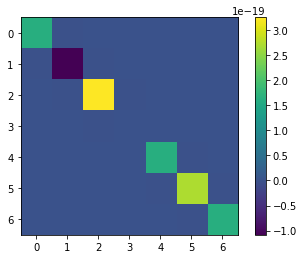

In [242]:
plt.imshow(residual)
plt.colorbar()

In [244]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
samples = 1000
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        hws = [hw]
        cws = [cw]
        filters = filter_bank(hws, cws)
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            normed_filters = (filters.T * filter_constants).T
            sigma_f = np.dot(normed_filters, normed_filters.T)
            fs = np.dot(normed_filters[:, :-1], spatial_signals.T)
            sigma_s = np.dot(fs, fs.T)
            sigma_n = input_noise**2 * sigma_f + output_noise**2
            sigma_signal = sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_snr, 10.9 * np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [07:23, 22.19s/it]


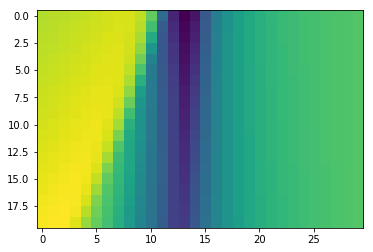

In [245]:
plt.imshow(info_map)

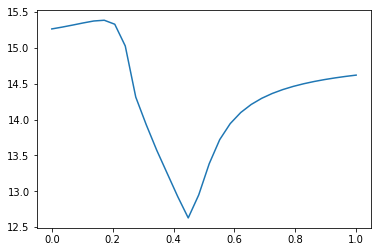

In [246]:
plt.plot(all_cws, info_map[10])

In [208]:
opt_filter_const

array([ 0.26524031,  0.26468666,  0.26464395,  0.26577139,  0.26682344,
        0.26668593,  0.2666665 ,  0.26680907,  0.26746812,  0.26836537,
        0.2681388 ,  0.26698288,  0.26549933,  0.26370305,  0.26200921,
        0.26105021,  0.26125551,  0.2611477 ,  0.26059371,  0.26171866,
        0.26283978,  0.26325091,  0.26560934,  0.26787841,  0.26776197,
        0.2672891 ,  0.26826093,  0.26971129,  0.27065419,  0.27046716,
        0.26911687,  0.2675315 ,  0.26616221])

In [209]:
filters.shape

(33, 399)

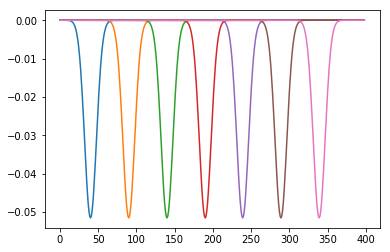

In [220]:
plt.plot(filters.T);

In [217]:
chol_t

3.2812191530202504

In [218]:
chol_n

-26.600321246701611

In [248]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [266]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [00:20,  1.04s/it]


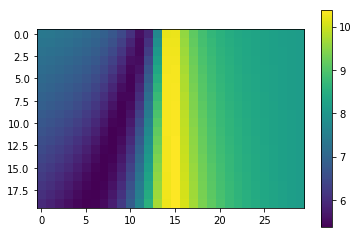

In [274]:
plt.imshow(info_map)
plt.colorbar()

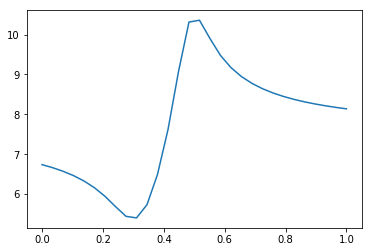

In [269]:
plt.plot(all_cws, info_map[10])

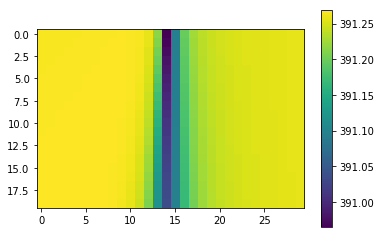

In [271]:
plt.imshow(snr_map)
plt.colorbar()

In [272]:
filters = filter_bank([0.5], [0.7])

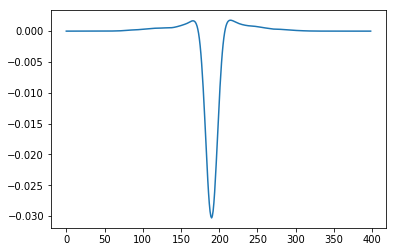

In [273]:
plt.plot(filters[3])

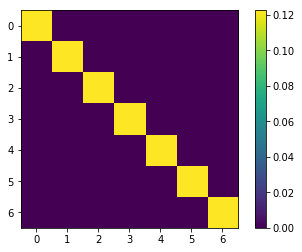

In [278]:
plt.imshow(sigma_n)
plt.colorbar()

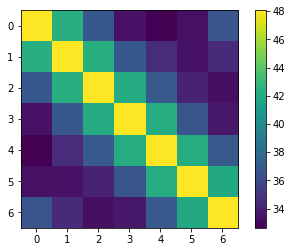

In [277]:
plt.imshow(sigma_t)
plt.colorbar()

In [279]:
all_hws = np.linspace(0, 1, 20)
all_cws = np.linspace(0, 1, 30)
info_map = np.zeros((20, 30))
snr_map = np.zeros((20, 30))
spatial_signals = 10. * generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
#         sigma_f = np.cov(filters)
#         sigma_s = np.cov(np.dot(filters[:, :-1], spatial_signals.T))
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
#             sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            nn = input_noise**2 * np.eye(filters.shape[-1])
            fn = np.dot(np.dot(filters, nn), filters.T)
            sigma_n = fn + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        snr = sigmas(opt_filter_const, return_flag='snr')
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi
        snr_map[idh, idc] = np.mean(snr)

20it [02:18,  6.49s/it]


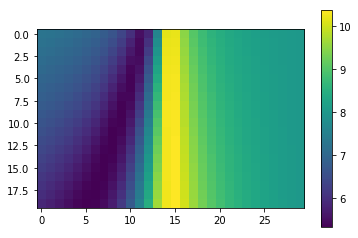

In [280]:
plt.imshow(info_map)
plt.colorbar()

# Okay we've settled on the following:

In [281]:
def filter_bank(hws, cws):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = rf_model(hw, cw)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [282]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826
# target_power = 100.
# target_snr = 0.5

In [620]:
hw_res = 60
cw_res = 80
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
            ff_const = np.outer(filter_constants, filter_constants)
            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            if return_flag == 'snr':
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)
        
        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(sigma_f.shape[0], 1))
        opt_filter_const = abs(res.x)
        
        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

60it [01:45,  1.78s/it]


(0, 1)

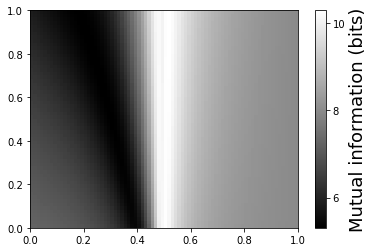

In [621]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

In [622]:
np.unravel_index(np.argmax(info_map), (60, 80))

(59, 41)

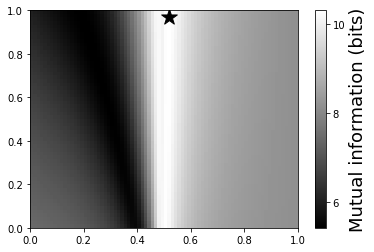

In [317]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')

In [291]:
info_map.shape

(60, 80)

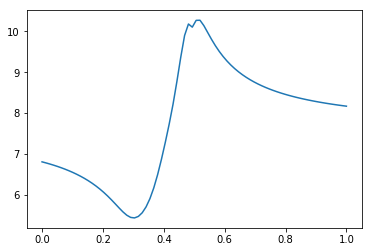

In [293]:
plt.plot(all_cws, info_map[30])

In [618]:
hw_res = 20
cw_res = 30
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        filters = filter_bank([hw], [cw])
        sigma_f = np.dot(filters, filters.T)
        fs = np.dot(filters[:, :-1], spatial_signals.T)
        sigma_s = np.dot(fs, fs.T)

        def sigmas(filter_constants, return_flag='sigmas'):
#             ff_types = np.outer(filter_constants, filter_constants)
#             ff_const = np.repeat(
#                 np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
#                 [num_repeat, num_repeat], axis=-1)
            ff_types = filter_constants**2
            ff_const = np.ones((7, 7)) * ff_types

            sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
            sigma_signal = ff_const * sigma_s
            sigma_t = sigma_signal + sigma_n

            if return_flag == 'snr':
                signal_var = np.diag(sigma_signal)
                noise_var = np.diag(sigma_n)
                snr = signal_var/noise_var
                return snr
            elif return_flag == 'sigmas':
                return sigma_t, sigma_n
            elif return_flag == 'power':
                return np.diag(sigma_t)

        def mse_snr(filter_constants):
            snr = sigmas(filter_constants, return_flag='snr')
            return np.mean((snr - target_snr)**2)

        def mse_power(filter_constants):
            power = sigmas(filter_constants, return_flag='power')
            return np.mean((power - target_power)**2)

        res = scipy.optimize.minimize(mse_power, np.random.rand(1))
        opt_filter_const = abs(res.x)

        sigma_t, sigma_n = sigmas(opt_filter_const)
        chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
        chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
        mi =  0.5 * (chol_t - chol_n)
        info_map[idh, idc] = mi

20it [00:02,  7.99it/s]


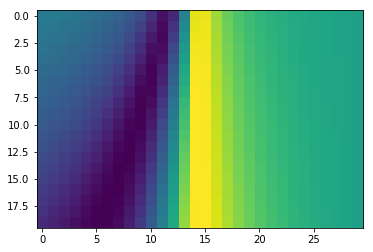

In [359]:
plt.imshow(info_map)

# Now for multiple dimensions

In [510]:
hw_res = 6
cw_res = 8
all_hws = np.linspace(0, 1, hw_res)
all_cws = np.linspace(0, 1, cw_res)
info_map = np.zeros((hw_res, cw_res, hw_res, cw_res))
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7
for idh, hw in tqdm(enumerate(all_hws)):
    for idc, cw in enumerate(all_cws):
        for idh2, hw2 in enumerate(all_hws):
            for idc2, cw2 in enumerate(all_cws):
                filters = filter_bank([hw, hw2], [cw, cw2])
                sigma_f = np.dot(filters, filters.T)
                fs = np.dot(filters[:, :-1], spatial_signals.T)
                sigma_s = np.dot(fs, fs.T)

                def sigmas(filter_constants, return_flag='sigmas'):
                    ff_types = np.outer(filter_constants, filter_constants)
                    ff_const = np.repeat(
                        np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
                        [num_repeat, num_repeat], axis=-1)
                    
                    sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
                    sigma_signal = ff_const * sigma_s
                    sigma_t = sigma_signal + sigma_n

                    if return_flag == 'snr':
                        signal_var = np.diag(sigma_signal)
                        noise_var = np.diag(sigma_n)
                        snr = signal_var/noise_var
                        return snr
                    elif return_flag == 'sigmas':
                        return sigma_t, sigma_n
                    elif return_flag == 'power':
                        return np.diag(sigma_t)

                def mse_snr(filter_constants):
                    snr = sigmas(filter_constants, return_flag='snr')
                    return np.mean((snr - target_snr)**2)

                def mse_power(filter_constants):
                    power = sigmas(filter_constants, return_flag='power')
                    return np.mean((power - target_power)**2)

                res = scipy.optimize.minimize(mse_power, np.random.rand(2, 1))
                opt_filter_const = abs(res.x)

                sigma_t, sigma_n = sigmas(opt_filter_const)
                chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
                chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
                mi =  0.5 * (chol_t - chol_n)
                info_map[idh, idc, idh2, idc2] = mi


0it [00:00, ?it/s]
6it [00:18,  3.11s/it]


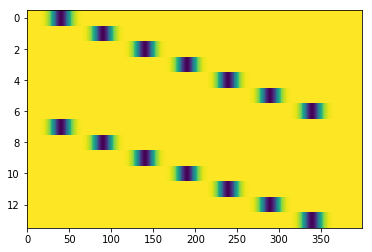

In [511]:
plt.imshow(filters, aspect='auto')

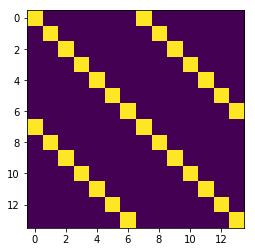

In [512]:
plt.imshow(sigma_f)

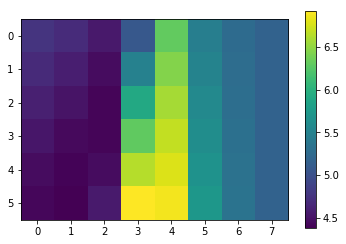

In [513]:
plt.imshow(info_map[:, :, 0, 0])
plt.colorbar()

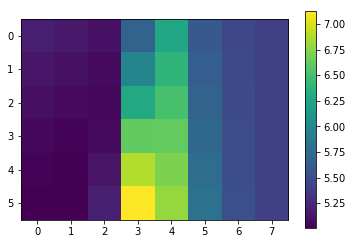

In [514]:
plt.imshow(info_map[:, :, -1, -1])
plt.colorbar()

In [515]:
np.unravel_index(np.argmax(info_map), [6, 8, 6, 8])

(5, 4, 5, 3)

In [516]:
all_hws

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [517]:
all_cws

array([ 0.        ,  0.14285714,  0.28571429,  0.42857143,  0.57142857,
        0.71428571,  0.85714286,  1.        ])

In [518]:
info_map[5, 4, 5, 3]

7.9340717011470794

In [522]:
info_map[5, 4, 0, 3]

7.4318000627026111

# Optimization for multiple dimensions

In [568]:
samples = 1000
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7

def neg_mutual_information(weights):
    num_filters = len(weights)//2
    hws = weights[:num_filters]
    cws = weights[num_filters:]
    filters = filter_bank(hws, cws)
    sigma_f = np.dot(filters, filters.T)
    fs = np.dot(filters[:, :-1], spatial_signals.T)
    sigma_s = np.dot(fs, fs.T)

    def sigmas(filter_constants, return_flag='sigmas'):
        if len(filter_constants) == 1:
            ff_types = filter_constants**2
            ff_const = np.ones((num_repeat, num_repeat)) * ff_types
        else:
            ff_types = np.outer(filter_constants, filter_constants)
            ff_const = np.repeat(
                np.repeat(ff_types, num_filters * [num_repeat], axis=0),
                num_filters * [num_repeat], axis=-1)

        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n

        if return_flag == 'snr':
            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            return snr
        elif return_flag == 'sigmas':
            return sigma_t, sigma_n
        elif return_flag == 'power':
            return np.diag(sigma_t)

    def mse_snr(filter_constants):
        snr = sigmas(filter_constants, return_flag='snr')
        return np.mean((snr - target_snr)**2)

    def mse_power(filter_constants):
        power = sigmas(filter_constants, return_flag='power')
        return np.mean((power - target_power)**2)

    res = scipy.optimize.minimize(mse_power, np.random.rand(num_filters, 1))
    opt_filter_const = abs(res.x)

    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    mi =  0.5 * (chol_t - chol_n)
    return -mi + 20

In [428]:
# res = scipy.optimize.minimize(neg_mutual_information, [0.6, 0.5], bounds=[[0,1], [0,1]])
# res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2), method='Nelder-Mead')
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2), bounds=[[0,1], [0,1]])

In [429]:
res

      fun: 1.8102641568524298
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.56794676,  0.84874738])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 6
   status: 0
  success: True
        x: array([ 0.72114908,  0.51354084])

In [430]:
-1 * (neg_mutual_information(res.x) - 12)

10.189735861626072

In [437]:
-1 * (neg_mutual_information([0.95, 0.5135]) - 12)

10.189664875507074

# Okay this is reasonable, now try multiple filters

In [452]:
num_filters = 2
res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                              bounds=[[0,1] for _ in range(2 * num_filters)])

In [453]:
res

      fun: 5.5185275614421929
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.37701362,  2.24948788,  4.54959856,  1.38873393])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 130
      nit: 3
   status: 0
  success: True
        x: array([ 0.6509576 ,  0.84412632,  0.41562607,  0.49678954])

In [455]:
lowest_fun = 100
all_x = []
all_fun = []
iterations = 20
num_filters = 2
for i in tqdm(range(iterations)):
    res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                  bounds=[[0,1] for _ in range(2 * num_filters)])
    if res.fun < lowest_fun:
        lowest_fun = res.fun
        opt_x = res.x
    all_x.append(res.x)
    all_fun.append(res.fun)

100%|██████████| 20/20 [00:31<00:00,  1.68s/it]


In [456]:
lowest_fun

4.9891062860913209

In [457]:
opt_x

array([ 0.09782949,  0.0510711 ,  0.64926003,  0.48722094])

In [458]:
all_x

[array([ 0.83011646,  0.68246612,  0.50000187,  0.41081372]),
 array([ 0.88194722,  0.22388157,  0.47676459,  0.62043989]),
 array([ 0.83838358,  0.98535928,  0.47543414,  0.5990201 ]),
 array([ 0.96196531,  0.1393755 ,  0.48015626,  0.99720103]),
 array([ 0.49237761,  0.30937187,  0.53695652,  0.47599806]),
 array([ 0.26255302,  0.18712264,  0.48467927,  0.67612898]),
 array([ 0.90800276,  0.78216285,  0.36818251,  0.49418067]),
 array([ 0.68430134,  0.95188016,  0.58202254,  0.47294084]),
 array([ 0.09782949,  0.0510711 ,  0.64926003,  0.48722094]),
 array([ 0.41501455,  0.81018983,  0.41724329,  0.4943723 ]),
 array([ 0.93244227,  0.7810894 ,  0.77187855,  0.48034918]),
 array([ 0.27039064,  0.75145161,  0.00171769,  0.48509885]),
 array([ 0.91556683,  0.55491477,  0.31840479,  0.4914179 ]),
 array([ 0.73887788,  0.64697366,  0.36166297,  0.49186027]),
 array([ 0.43528353,  0.64319376,  0.31940855,  0.48916952]),
 array([ 0.76376636,  0.95599439,  0.08241925,  0.48470963]),
 array([

In [461]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 20
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

 20%|██        | 2/10 [00:36<01:45, 13.18s/it]

ValueError: operands could not be broadcast together with shape (3,) (2,)

In [531]:
samples = 1000
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7
target_power = 48.

def mutual_information(weights):
    num_filters = len(weights)//2
    hws = weights[:num_filters]
    cws = weights[num_filters:]
    filters = filter_bank(hws, cws)
    sigma_f = np.dot(filters, filters.T)
    fs = np.dot(filters[:, :-1], spatial_signals.T)
    sigma_s = np.dot(fs, fs.T)

    def sigmas(filter_constants, return_flag='sigmas'):
        if len(filter_constants) == 1:
            ff_types = filter_constants**2
            ff_const = np.ones((num_repeat, num_repeat)) * ff_types
        else:
            ff_types = np.outer(filter_constants, filter_constants)
            ff_const = np.repeat(
                np.repeat(ff_types, [num_repeat, num_repeat], axis=0),
                [num_repeat, num_repeat], axis=-1)

        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n

        if return_flag == 'snr':
            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            return snr
        elif return_flag == 'sigmas':
            return sigma_t, sigma_n
        elif return_flag == 'power':
            return np.diag(sigma_t)

    def mse_snr(filter_constants):
        snr = sigmas(filter_constants, return_flag='snr')
        return np.mean((snr - target_snr)**2)

    def mse_power(filter_constants):
        power = sigmas(filter_constants, return_flag='power')
        return np.mean((power - target_power)**2)

    res = scipy.optimize.minimize(mse_power, np.random.rand(num_filters, 1))
    opt_filter_const = abs(res.x)

    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    mi =  0.5 * (chol_t - chol_n)
    return mi

In [532]:
mutual_information([0, 1, 0.515, 0.515])

12.871094404909719

In [533]:
mutual_information([0.5, 0.5, 0.515, 0.515])

11.302971038209792

In [534]:
mutual_information([0, 0, 0.515, 0.515])

11.217716127579031

In [535]:
mutual_information([1, 1, 0.515, 0.515])

11.322947100190053

In [536]:
mutual_information([0, 0, 0.498, 0.6])

14.676913231125523

In [537]:
mutual_information([0, 1, 0.498, 0.6])

15.064666211084074

In [539]:
mutual_information([0, 0.515])

10.083163207346827

In [569]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 20
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))


100%|██████████| 10/10 [2:50:30<00:00, 1901.13s/it]


In [570]:
optimal_fun

[10.193981640537,
 15.683144488712159,
 17.327113394244982,
 18.024961145855762,
 19.021503259669402,
 19.335681199688906,
 19.666138053306099,
 19.953761920310338,
 20.596030329578689,
 20.947160283597821]

In [573]:
optimal_filters

[array([ 0.98455707,  0.51586888]),
 array([ 0.04873504,  0.96200546,  0.47579175,  0.51734987]),
 array([ 0.        ,  0.93695017,  0.82187966,  0.48502159,  0.77537927,
         0.48502394]),
 array([ 0.42658536,  0.70158612,  0.80914659,  0.        ,  0.38544313,
         0.75271437,  0.48602973,  0.48571276]),
 array([  3.29917835e-04,   9.40124521e-01,   7.76518753e-01,
          0.00000000e+00,   2.55378561e-01,   4.89247245e-01,
          4.87163150e-01,   1.20801227e-01,   4.81732568e-01,
          4.28714632e-02]),
 array([ 0.21533258,  0.59246314,  0.        ,  0.32048085,  0.60454357,
         0.99964632,  0.96156943,  0.48754164,  0.48687401,  0.18269853,
         0.07582163,  0.48316709]),
 array([ 0.62770228,  0.50368164,  0.47346504,  0.        ,  0.62657281,
         0.68267236,  0.98500863,  0.49277643,  0.02727202,  0.15816437,
         0.48750857,  0.21537904,  0.92608099,  0.47681022]),
 array([ 0.51826417,  0.96025759,  0.61271171,  0.12700574,  0.44903477,
       

In [574]:
optimal_hws = []
optimal_cws = []
for weights in optimal_filters:
    n = len(weights)//2
    optimal_hws.append(weights[:n])
    optimal_cws.append(weights[n:])

In [575]:
optimal_hws

[array([ 0.98455707]),
 array([ 0.04873504,  0.96200546]),
 array([ 0.        ,  0.93695017,  0.82187966]),
 array([ 0.42658536,  0.70158612,  0.80914659,  0.        ]),
 array([  3.29917835e-04,   9.40124521e-01,   7.76518753e-01,
          0.00000000e+00,   2.55378561e-01]),
 array([ 0.21533258,  0.59246314,  0.        ,  0.32048085,  0.60454357,
         0.99964632]),
 array([ 0.62770228,  0.50368164,  0.47346504,  0.        ,  0.62657281,
         0.68267236,  0.98500863]),
 array([ 0.51826417,  0.96025759,  0.61271171,  0.12700574,  0.44903477,
         0.        ,  0.69897588,  0.35146629]),
 array([ 0.13186836,  0.86534127,  0.        ,  0.68905079,  0.70328228,
         0.83522623,  0.21148156,  0.56264993,  0.69133115]),
 array([ 0.84176381,  0.46784268,  0.44250908,  1.        ,  0.02301024,
         0.8974873 ,  0.02159803,  0.07772438,  0.58826332,  0.        ])]

In [576]:
optimal_cws

[array([ 0.51586888]),
 array([ 0.47579175,  0.51734987]),
 array([ 0.48502159,  0.77537927,  0.48502394]),
 array([ 0.38544313,  0.75271437,  0.48602973,  0.48571276]),
 array([ 0.48924724,  0.48716315,  0.12080123,  0.48173257,  0.04287146]),
 array([ 0.96156943,  0.48754164,  0.48687401,  0.18269853,  0.07582163,
         0.48316709]),
 array([ 0.49277643,  0.02727202,  0.15816437,  0.48750857,  0.21537904,
         0.92608099,  0.47681022]),
 array([ 0.6490634 ,  0.47952737,  0.62840236,  0.98915679,  0.48485768,
         0.48658944,  0.07314042,  0.241638  ]),
 array([ 0.47771009,  0.46744536,  0.48547191,  0.49823621,  0.82738485,
         0.93178264,  0.77514767,  0.73166731,  0.48263795]),
 array([ 0.88487385,  0.        ,  0.98371045,  0.62212265,  0.6213931 ,
         0.48169198,  0.48763364,  0.00158481,  0.47274648,  0.48610305])]

In [585]:
flattened_opt_hws = []
flattened_num_filters = []
for i, hws in enumerate(optimal_hws):
    for hw in hws:
        flattened_opt_hws.append(hw)
        flattened_num_filters.append(i+1)

In [579]:
flattened_opt_cws = []
flattened_num_filters = []
for i,cws in enumerate(optimal_cws):
    for cw in cws:
        flattened_opt_cws.append(cw)
        flattened_num_filters.append(i+1)

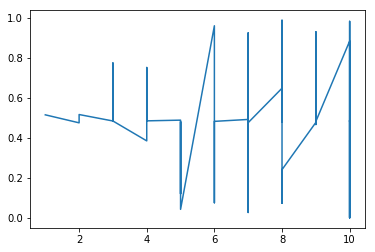

In [580]:
plt.plot(flattened_num_filters, flattened_opt_cws)

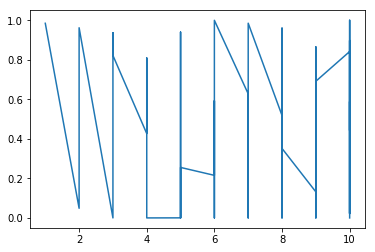

In [586]:
plt.plot(flattened_num_filters, flattened_opt_hws)

# For pretty diagrams, I'm going to sort hw and cw

In [590]:
sorted_optimal_cws = [sorted(cws) for cws in optimal_cws]
sorted_optimal_hws = [sorted(hws) for hws in optimal_hws]

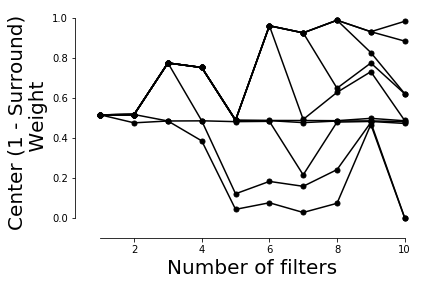

In [606]:
for depth in range(len(sorted_optimal_cws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_cws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_cws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Center (1 - Surround) \n Weight', fontsize=20)
plt.xlabel('Number of filters', fontsize=20)
adjust_spines(plt.gca())

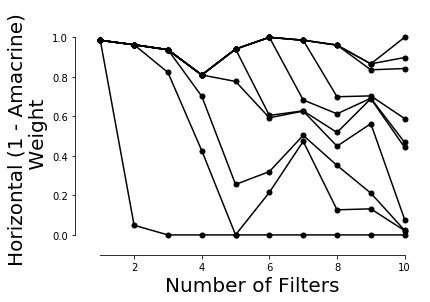

In [605]:
for depth in range(len(sorted_optimal_hws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_hws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_hws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Horizontal (1 - Amacrine) \n Weight', fontsize=20)
plt.xlabel('Number of Filters', fontsize=20)
adjust_spines(plt.gca())

In [617]:
multidimensional_info_map = info_map

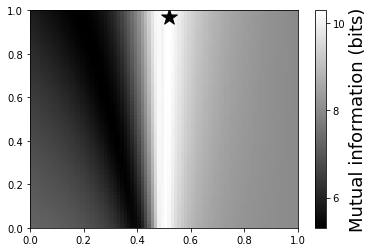

In [624]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')

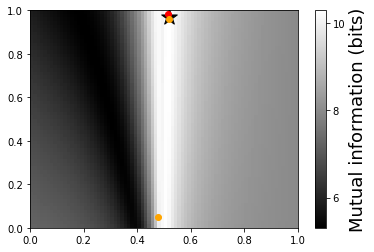

In [635]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
# plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
# plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
# plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
# plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

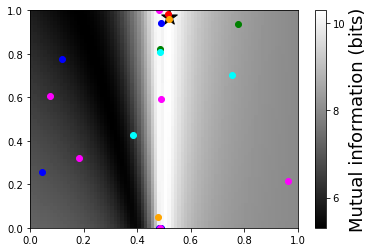

In [634]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

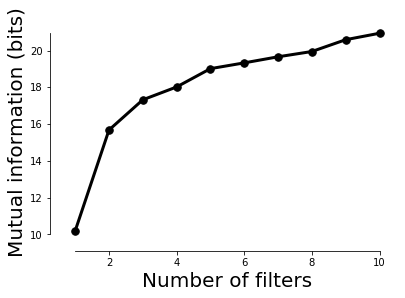

In [642]:
plt.plot(np.arange(1,11), optimal_fun, 'k', linewidth=3, marker='.', markersize=15)
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
adjust_spines(plt.gca())

# Run for even longer

In [644]:
optimal_filters_backup = optimal_filters
optimal_fun_backup = optimal_fun
all_x_backup = all_x
all_fun_backup = all_fun

In [ ]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 100
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

 50%|█████     | 5/10 [1:22:15<1:41:00, 1212.12s/it]

In [647]:
optimal_filters

[array([ 0.15525143,  0.48805898]),
 array([ 0.        ,  0.78025912,  0.47750112,  0.5158944 ]),
 array([ 0.        ,  0.64101593,  1.        ,  0.48661446,  0.9996043 ,
         0.48604646]),
 array([ -6.93889390e-18,   9.91479997e-01,   9.64580094e-01,
          2.22787585e-02,   4.87249303e-01,   4.85100616e-01,
          9.44682063e-01,   6.61698384e-03]),
 array([ 0.        ,  0.99512756,  0.32351517,  0.99410405,  0.99720333,
         0.48664033,  0.96416754,  0.86130335,  0.48291405,  0.48369107]),
 array([ 0.        ,  0.74386868,  0.0710295 ,  0.81983853,  0.75399413,
         0.7918184 ,  0.48692272,  0.48513921,  0.20215807,  0.68248127,
         0.01528707,  0.48398482]),
 array([ 0.99626895,  0.44853703,  0.14259241,  0.06618063,  0.62257344,
         0.00291366,  0.16757889,  0.48905323,  0.12073934,  0.47828765,
         0.913673  ,  0.48189991,  0.48374137,  0.62975855]),
 array([  1.25120644e-01,   4.83702215e-01,   9.39058243e-02,
          6.00018136e-01,   1.722184

In [650]:
optimal_hws_backup = optimal_hws
optimal_cws_backup = optimal_cws

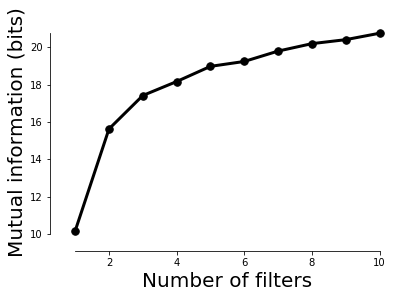

In [648]:
plt.plot(np.arange(1,11), optimal_fun, 'k', linewidth=3, marker='.', markersize=15)
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
adjust_spines(plt.gca())

In [651]:
optimal_hws = []
optimal_cws = []
for weights in optimal_filters:
    n = len(weights)//2
    optimal_hws.append(weights[:n])
    optimal_cws.append(weights[n:])

In [652]:
sorted_optimal_cws = [sorted(cws) for cws in optimal_cws]
sorted_optimal_hws = [sorted(hws) for hws in optimal_hws]

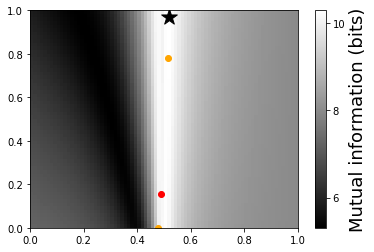

In [653]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.scatter(all_cws[41], all_hws[59] - 0.03, color='k', s=270, marker='*')
plt.scatter(optimal_cws[0], optimal_hws[0], color='r')
plt.scatter(optimal_cws[1], optimal_hws[1], color='orange')
# plt.scatter(optimal_cws[2], optimal_hws[2], color='green')
# plt.scatter(optimal_cws[3], optimal_hws[3], color='cyan')
# plt.scatter(optimal_cws[4], optimal_hws[4], color='blue')
# plt.scatter(optimal_cws[5], optimal_hws[5], color='magenta')

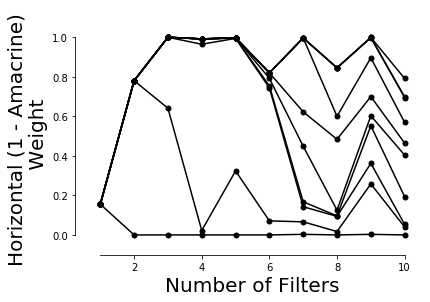

In [654]:
for depth in range(len(sorted_optimal_hws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_hws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_hws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Horizontal (1 - Amacrine) \n Weight', fontsize=20)
plt.xlabel('Number of Filters', fontsize=20)
adjust_spines(plt.gca())

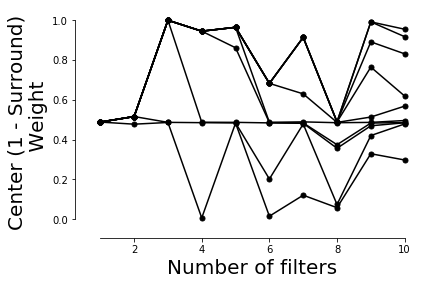

In [655]:
for depth in range(len(sorted_optimal_cws[-1])):
    this_series = []
    for num_filt in range(num_filters):
        index = np.min([len(sorted_optimal_cws[num_filt]) - 1, depth])
        this_series.append(sorted_optimal_cws[num_filt][index])
    plt.plot(np.arange(1, 11), this_series, 'k', marker='.', markersize=10)
plt.ylabel('Center (1 - Surround) \n Weight', fontsize=20)
plt.xlabel('Number of filters', fontsize=20)
adjust_spines(plt.gca())

# Addressing Steve's comments

In [656]:
optimal_hws_backup

[array([ 0.98455707]),
 array([ 0.04873504,  0.96200546]),
 array([ 0.        ,  0.93695017,  0.82187966]),
 array([ 0.42658536,  0.70158612,  0.80914659,  0.        ]),
 array([  3.29917835e-04,   9.40124521e-01,   7.76518753e-01,
          0.00000000e+00,   2.55378561e-01]),
 array([ 0.21533258,  0.59246314,  0.        ,  0.32048085,  0.60454357,
         0.99964632]),
 array([ 0.62770228,  0.50368164,  0.47346504,  0.        ,  0.62657281,
         0.68267236,  0.98500863]),
 array([ 0.51826417,  0.96025759,  0.61271171,  0.12700574,  0.44903477,
         0.        ,  0.69897588,  0.35146629]),
 array([ 0.13186836,  0.86534127,  0.        ,  0.68905079,  0.70328228,
         0.83522623,  0.21148156,  0.56264993,  0.69133115]),
 array([ 0.84176381,  0.46784268,  0.44250908,  1.        ,  0.02301024,
         0.8974873 ,  0.02159803,  0.07772438,  0.58826332,  0.        ])]

In [677]:
np.repeat(optimal_filters_backup[0], 3)

array([ 0.98455707,  0.98455707,  0.98455707,  0.51586888,  0.51586888,
        0.51586888])

In [663]:
mutual_information(optimal_filters_backup[0])

10.169144348467755

In [693]:
-1*(neg_mutual_information(optimal_filters_backup[0]) - 20)

10.195115899930164

In [694]:
single_optimal_fun = [-1*(neg_mutual_information(
    np.repeat(optimal_filters_backup[0], i)) - 20) for i in np.arange(1, 11)]

In [696]:
np.repeat(optimal_filters_backup[0][1], 2)

array([ 0.51586888,  0.51586888])

In [700]:
splitting_hws_fun = []
for i in np.arange(1, 11):
    these_cws = np.repeat(optimal_filters_backup[0][1], i)
    these_hws = np.linspace(0, 1, i)
    if i == 1:
        these_hws = 1.0
    weights = np.zeros((2 * i, ))
    weights[:i] = these_hws
    weights[i:] = these_cws
    splitting_hws_fun.append(-1 * (neg_mutual_information(weights) - 20))

In [706]:
splitting_cws_fun = []
for i in np.arange(1, 11):
    these_hws = np.repeat(optimal_filters_backup[0][0], i)
    these_cws = np.linspace(0, 1, i)
    if i == 1:
        these_cws = optimal_filters_backup[0][1]
    weights = np.zeros((2 * i, ))
    weights[:i] = these_hws
    weights[i:] = these_cws
    splitting_cws_fun.append(-1 * (neg_mutual_information(weights) - 20))

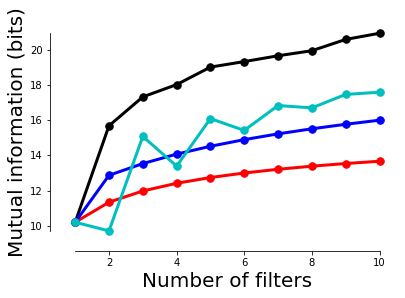

In [709]:
plt.plot(np.arange(1,11), optimal_fun_backup, 'k', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), single_optimal_fun, 'r', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), splitting_hws_fun, 'b', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
adjust_spines(plt.gca())

# Single cell versus multi-cell information scatterplot

In [710]:
def mutual_information(weights):
    return -1. * (neg_mutual_information(weights) - 20)

In [713]:
def mean_single_cell_mi(weights):
    num_filters = len(weights)//2
    all_hws = weights[:num_filters]
    all_cws = weights[num_filters:]
    infos = []
    for f in range(num_filters):
        infos.append(mutual_information(np.array([all_hws[f], all_cws[f]])))
    return np.mean(infos)

In [ ]:
single_cell_info = collections.defaultdict(list)
multi_cell_info = collections.defaultdict(list)
iterations = 1000
for num_filt in range(1, 11):
    for i in tqdm(range(iterations)):
        random_weights = np.random.rand(num_filt * 2)
        multi_cell_info[num_filt].append(mutual_information(random_weights))
        single_cell_info[num_filt].append(mean_single_cell_mi(random_weights))

 63%|██████▎   | 634/1000 [01:12<00:40,  8.98it/s]

In [721]:
single_cell_info.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [722]:
multi_cell_info.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

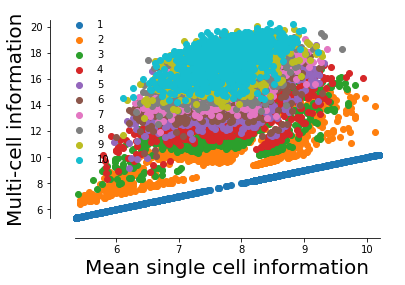

In [738]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

# Now plot our cells on this scatter plot

In [740]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

In [742]:
fits = np.load(expanduser('~/data/surround/fits_2017-05-20.npy')).item()

In [743]:
fits.keys()

dict_keys(['medium_off_adapting', 'fast_on', 'fast_off_sensitizing', 'fast_off_adapting', 'slow_off', 'ganglion'])

In [744]:
fits['medium_off_adapting'].shape

(159, 2)

In [751]:
np.random.choice(159, 2)

array([127,  74])

In [754]:
blah = fits['medium_off_adapting'][np.random.choice(159, 3)]

In [755]:
blah

array([[ 0.26774261,  0.61138685],
       [ 0.13272048,  0.66649753],
       [ 0.66887167,  0.46751016]])

In [758]:
blah.flatten(order='F')

array([ 0.26774261,  0.13272048,  0.66887167,  0.61138685,  0.66649753,
        0.46751016])

In [777]:
mutual_information(fits['medium_off_adapting'][np.random.choice(159)])

6.2833783765806146

In [760]:
mutual_information(blah.flatten(order='F'))

15.348780620497935

In [778]:
def random_sample_real_weights(num, celltype='medium_off_adapting'):
    max_cells = fits[celltype].shape[0]
    these_fits = fits[celltype][np.random.choice(max_cells, num)]
    return these_fits.flatten(order='F')

In [787]:
iterations = 1000
mean_data_info_vs_filters = []
sem_data_info_vs_filters = []
data_multicell_info = collections.defaultdict(list)
data_singlecell_info = collections.defaultdict(list)
for num_filt in range(1, 11):
    for i in tqdm(range(iterations)):
        these_weights = random_sample_real_weights(num_filt)
        data_singlecell_info[num_filt].append(mean_single_cell_mi(these_weights))
        data_multicell_info[num_filt].append(mutual_information(these_weights))
    mean_data_info_vs_filters.append(np.mean(data_multicell_info[num_filt]))
    sem_data_info_vs_filters.append(sem(data_multicell_info[num_filt]))

100%|██████████| 1000/1000 [02:52<00:00,  5.82it/s]


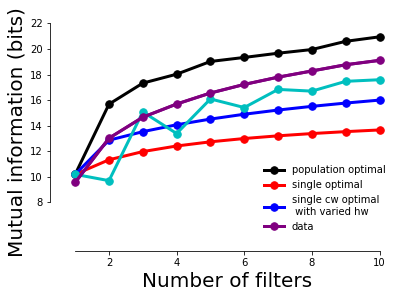

In [953]:
plt.plot(np.arange(1,11), optimal_fun_backup, 'k', linewidth=3, marker='.', markersize=15, label='population optimal')
plt.plot(np.arange(1,11), single_optimal_fun, 'r', linewidth=3, marker='.', markersize=15, label='single optimal')
plt.plot(np.arange(1,11), splitting_hws_fun, 'b', linewidth=3, marker='.', markersize=15, label='single cw optimal \n with varied hw')
plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), mean_data_info_vs_filters, linewidth=3, color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), mean_data_info_vs_filters, yerr=sem_data_info_vs_filters, linewidth=3, color='purple')
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False)
plt.ylim(5, 22)
adjust_spines(plt.gca())

In [812]:
colors = plt.get_cmap('winter')(np.linspace(0, 1, 10))
data_colors = plt.get_cmap('gray')(np.linspace(0, 1, 10))[::-1]

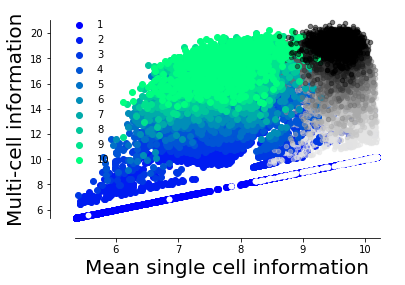

In [819]:
for i in range(1, 11):
    plt.scatter(single_cell_info[i], multi_cell_info[i], label=i, color=colors[i-1])
    plt.scatter(data_singlecell_info[i], data_multicell_info[i], color=data_colors[i-1], alpha=0.5, s=20)
# plt.scatter(single_cell_info[2], multi_cell_info[2], color='blue')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
# plt.scatter(single_cell_info[3], multi_cell_info[3], color='cyan')
adjust_spines(plt.gca())
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Mean single cell information', fontsize=20)
plt.ylabel('Multi-cell information', fontsize=20)

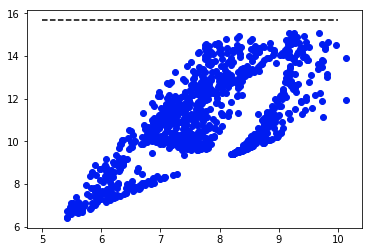

In [826]:
plt.scatter(single_cell_info[2], multi_cell_info[2], color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[1]], 'k--')

In [828]:
exhaustive_single_cell_info = []
exhaustive_multi_cell_info = []
iterations = 10000
num_filt = 2
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(num_filt * 2)
    exhaustive_multi_cell_info.append(mutual_information(random_weights))
    exhaustive_single_cell_info.append(mean_single_cell_mi(random_weights))

100%|██████████| 10000/10000 [03:12<00:00, 52.02it/s]


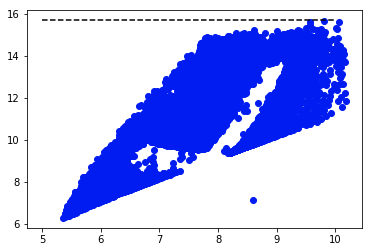

In [832]:
plt.scatter(exhaustive_single_cell_info, exhaustive_multi_cell_info, color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[1]], 'k--')

In [833]:
exhaustive_single_cell_info = []
exhaustive_multi_cell_info = []
iterations = 10000
num_filt = 3
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(num_filt * 2)
    exhaustive_multi_cell_info.append(mutual_information(random_weights))
    exhaustive_single_cell_info.append(mean_single_cell_mi(random_weights))

100%|██████████| 10000/10000 [07:00<00:00, 23.81it/s]


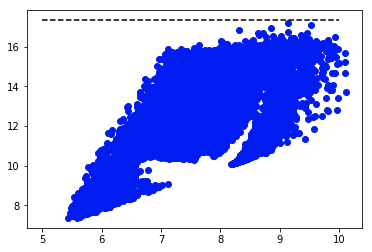

In [835]:
plt.scatter(exhaustive_single_cell_info, exhaustive_multi_cell_info, color=colors[1])
plt.plot(np.arange(5,11), 6*[optimal_fun_backup[2]], 'k--')

In [ ]:
for hw1 in tqdm(np.linspace(0, 1, 10)):
    for cw1 in np.linspace(0, 1, 10):
        for hw2 in np.linspace(0, 1, 10):
            for cw2 in np.linspace(0, 1, 10):
                

In [837]:
optimal_cws[-1]

array([ 0.91705767,  0.29761016,  0.48465955,  0.61892081,  0.95444018,
        0.49587522,  0.4787148 ,  0.83082595,  0.56817829,  0.48561776])

In [839]:
optimal_weights = np.concatenate([optimal_hws[-1], optimal_cws[-1]])

In [840]:
mean_single_cell_mi(optimal_weights)

8.9191182088079053

In [841]:
mutual_information(optimal_weights)

20.9046818869842

(0, 1)

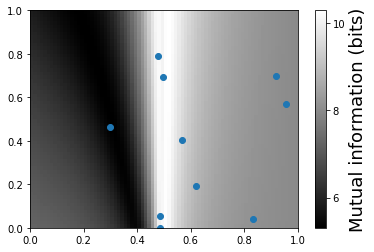

In [844]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

plt.scatter(optimal_cws[-1], optimal_hws[-1])
plt.xlim(0, 1)
plt.ylim(0, 1)

In [846]:
len(all_x)

100

In [847]:
len(all_fun)

100

<Container object of 20 artists>

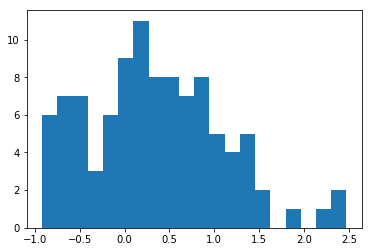

In [851]:
count, bins = np.histogram(all_fun, bins=20)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] - bin_width/2, count, width=bin_width)

(0, 1)

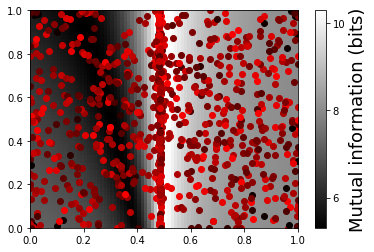

In [872]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx, soln in enumerate(all_x):
    soln_cws = soln[10:]
    soln_hws = soln[:10]
#     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [873]:
np.argmax(all_fun)

6

In [875]:
soln_cws

array([ 0.99903386,  0.48201683,  0.00273718,  0.23264698,  0.00374851,
        0.99660279,  0.00122167,  0.99907053,  0.00209193,  1.        ])

In [876]:
soln_hws

array([ 0.99578234,  0.99895731,  0.99946843,  0.99888679,  1.        ,
        0.89067552,  0.99999998,  0.99976388,  1.        ,  0.30814011])

In [877]:
optimal_fun

[10.171360854664602,
 15.628257899611546,
 17.416699238958707,
 18.164038140319846,
 18.97731126406498,
 19.238998544220831,
 19.794201007018437,
 20.192385935937018,
 20.405707775907377,
 20.749323913131363]

In [881]:
sorted_solns = np.argsort(all_fun)

In [885]:
sorted_solns[1]

32

(0, 1)

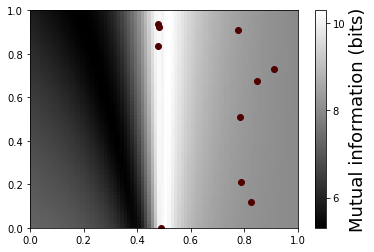

In [886]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
soln_cws = all_x[32][10:]
soln_hws = all_x[32][:10]
#     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

(0, 1)

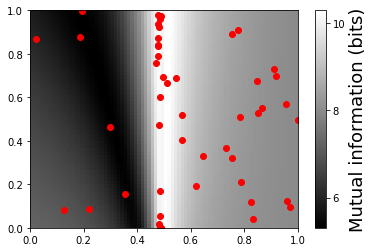

In [896]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = all_fun - np.min(all_fun)
normalized_fun /= np.max(normalized_fun)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx in sorted_solns[:5]:
    soln_cws = all_x[idx][10:]
    soln_hws = all_x[idx][:10]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [899]:
hw_subpop = []
cw_subpop = []
for idx in sorted_solns[:5]:
    hw_subpop.append(all_x[idx][:10])
    cw_subpop.append(all_x[idx][10:])

<Container object of 20 artists>

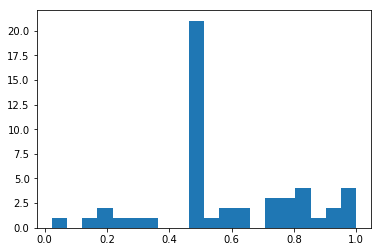

In [900]:
count, bins = np.histogram(cw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)

In [ ]:
optimal_filters = []
optimal_fun = []
for num_filters in tqdm(range(1, 11)):
    lowest_fun = 100
    all_x = []
    all_fun = []
    iterations = 100
    for i in range(iterations):
        res = scipy.optimize.minimize(neg_mutual_information, np.random.rand(2 * num_filters), 
                                      bounds=[[0,1] for _ in range(2 * num_filters)])
        if res.fun < lowest_fun:
            lowest_fun = res.fun
            opt_x = res.x
        all_x.append(res.x)
        all_fun.append(res.fun)
    optimal_filters.append(opt_x)
    optimal_fun.append(-(lowest_fun - 20))

In [902]:
num_filters

3

In [908]:
collection_of_optima = []
collection_of_funs = []
iterations = 20
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)

100%|██████████| 20/20 [02:46<00:00,  5.91s/it]


In [909]:
res.x

array([ 0.45468725,  0.56177885,  0.89416709,  0.39682908,  0.48668274,
        0.84782194])

In [910]:
random_weights

array([ 0.46341878,  0.56101987,  0.89213474,  0.40444954,  0.47682531,
        0.86410298])

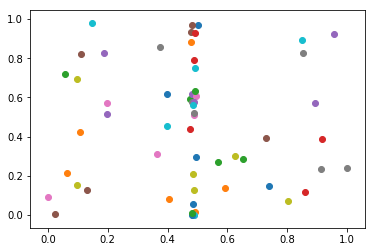

In [914]:
for soln in collection_of_optima:
    plt.scatter(soln[3:], soln[:3])

In [918]:
sorted_threed = np.argsort(collection_of_funs)
sorted_threed

array([ 3,  9,  0,  6, 12, 10, 13,  8,  1, 18, 19, 16,  7, 17,  4, 11, 15,
       14,  2,  5])

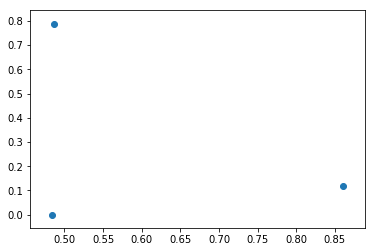

In [916]:
plt.scatter(collection_of_optima[3][3:], collection_of_optima[3][:3])

(0, 1)

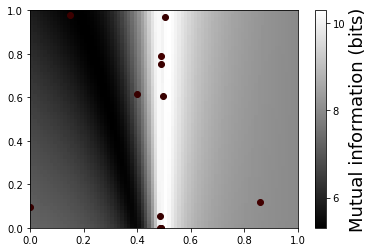

In [921]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = collection_of_funs - np.min(all_fun)
normalized_fun /= np.max(collection_of_funs)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx in sorted_threed[:4]:
    soln_cws = collection_of_optima[idx][3:]
    soln_hws = collection_of_optima[idx][:3]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [ ]:
collection_of_optima = []
collection_of_funs = []
iterations = 20
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)

In [922]:
collection_of_optima[sorted_threed[0]]

array([ 0.78912221,  0.11745659,  0.        ,  0.48704882,  0.86025323,
        0.48415724])

In [923]:
collection_of_funs[sorted_threed[0]]

2.662630729246743

In [927]:
res = scipy.optimize.minimize(neg_mutual_information, collection_of_optima[sorted_threed[0]],
                              bounds=[[0, 1] for _ in range(2 * num_filters)])

In [928]:
res.fun

2.6610892524195151

In [929]:
res.x

array([ 0.7896293 ,  0.12085244,  0.        ,  0.48876622,  0.86031711,
        0.4848395 ])

In [930]:
neg_mutual_information([0.7896293 ,  0.12085244,  0.        ,  0.48876622,  0.86031711,
        0.4848395])

2.6610892657389691

In [932]:
neg_mutual_information([0.7896293 ,  0.5085244,  0.        ,  0.48876622,  0.86031711,
        0.4848395])

2.6579451529498499

In [931]:
neg_mutual_information([0.7896293 ,  0.12085244,  0.        ,  0.48876622,  0.48831711,
        0.4848395])

4.3401113248361121

In [ ]:
collection_of_optima = []
collection_of_funs = []
iterations = 5000
num_filters = 4
for i in tqdm(range(iterations)):
    random_weights = np.random.rand(2 * num_filters)
    res = scipy.optimize.minimize(neg_mutual_information, random_weights, 
                                          bounds=[[0,1] for _ in range(2 * num_filters)])
    collection_of_optima.append(res.x)
    collection_of_funs.append(res.fun)


100%|██████████| 5000/5000 [21:40:39<00:00, 18.42s/it]  


In [938]:
sorted_fourd = np.argsort(collection_of_funs)
sorted_fourd

array([4899, 2534, 2962, ..., 2311, 1573, 4965])

(0, 1)

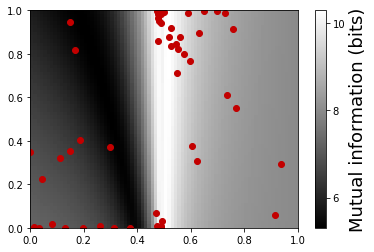

In [943]:
min_info = info_map.min()
max_info = info_map.max()
plt.imshow(info_map, cmap='gray', extent=(all_cws[0], all_cws[-1], all_hws[-1], all_hws[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])

normalized_fun = collection_of_funs - np.min(all_fun)
normalized_fun /= np.max(collection_of_funs)
normalized_fun -= 1.0
normalized_fun *= -1.0
for idx in sorted_fourd[:20]:
    soln_cws = collection_of_optima[idx][num_filters:]
    soln_hws = collection_of_optima[idx][:num_filters]
    #     plt.scatter(soln_cws, soln_hws, color='k', alpha=normalized_fun[idx])
    plt.scatter(soln_cws, soln_hws, color=[normalized_fun[idx], 0, 0])
    
plt.xlim(0, 1)
plt.ylim(0, 1)

In [951]:
hw_subpop = []
cw_subpop = []
for idx in sorted_fourd[:50]:
    hw_subpop.append(collection_of_optima[idx][:num_filters])
    cw_subpop.append(collection_of_optima[idx][num_filters:])

<Container object of 20 artists>

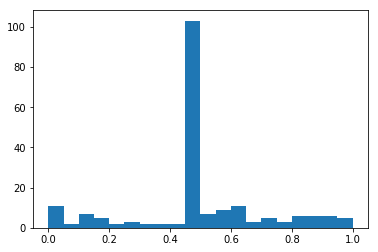

In [952]:
count, bins = np.histogram(cw_subpop, bins=20)
binwidth = np.mean(np.diff(bins))
plt.bar(bins[:-1] + binwidth/2.0, count, width=binwidth)